In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import fingerprint_enhancer
import random
from collections import Counter

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import class_weight
from tqdm import tqdm

In [3]:
# Dataset and config
data_dir = "./Public_Dataset"
img_size = (300, 400)
batch_size = 32
num_classes = 4

Dataset Class Distribution:
a: 1570 images
ab: 1465 images
b: 1389 images
o: 1560 images


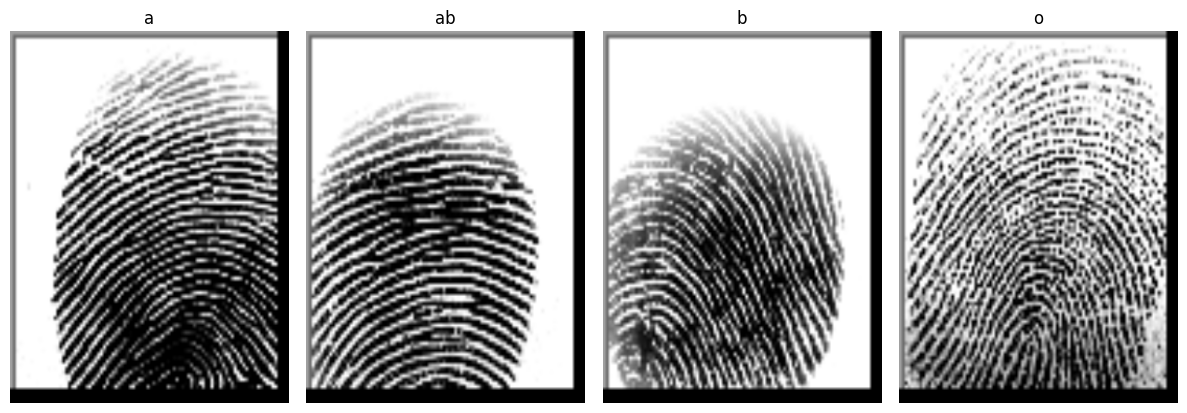

In [4]:
# Display dataset info
def display_dataset_info(data_dir):
    class_names = os.listdir(data_dir)
    class_count = {c: len(os.listdir(os.path.join(data_dir, c))) for c in class_names}
    
    print("Dataset Class Distribution:")
    for c, count in class_count.items():
        print(f"{c}: {count} images")
    
    plt.figure(figsize=(12, 8))
    for idx, c in enumerate(class_names):
        cpath = os.path.join(data_dir, c)
        sample_image_path = os.path.join(cpath, os.listdir(cpath)[0])
        img = cv2.imread(sample_image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        plt.subplot(2, 4, idx + 1)
        plt.imshow(img)
        plt.title(c)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_dataset_info(data_dir)

In [23]:
# Augmentation
def simple_augment(image):
    angle = random.uniform(-10, 10)
    h, w = image.shape
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    brightness_factor = random.uniform(0.8, 1.2)
    image = np.clip(image * brightness_factor, 0, 255)

    contrast_factor = random.uniform(0.8, 1.2)
    mean = np.mean(image)
    image = np.clip((image - mean) * contrast_factor + mean, 0, 255)

    return image.astype(np.uint8)

In [24]:
def apply_masked_processing(image):
    _, binary_mask = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY_INV)
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0.5)
    threshold_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 8
    )
    enhanced_fingerprint = cv2.bitwise_and(threshold_image, threshold_image, mask=binary_mask)
    background = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(binary_mask))
    final_image = cv2.add(enhanced_fingerprint, background)
    if np.std(final_image) < 5:
        return image
    return final_image

In [25]:
def preprocess_image(image_path, img_size, augment=False):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert image is not None, f"Could not read image: {image_path}"
    image = cv2.resize(image, img_size)

    image = apply_masked_processing(image)

    if augment:
        image = simple_augment(image)

    if np.std(image) >= 10:
        try:
            enhanced = fingerprint_enhancer.enhance_fingerprint(image)
            if enhanced is not None and np.std(enhanced) > 0:
                image = enhanced
        except Exception as e:
            print(f"Enhancement error for {image_path}: {e}")

    image = (image * 255).astype(np.uint8) if image.dtype != np.uint8 else image
    image = image / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

In [26]:
%matplotlib inline

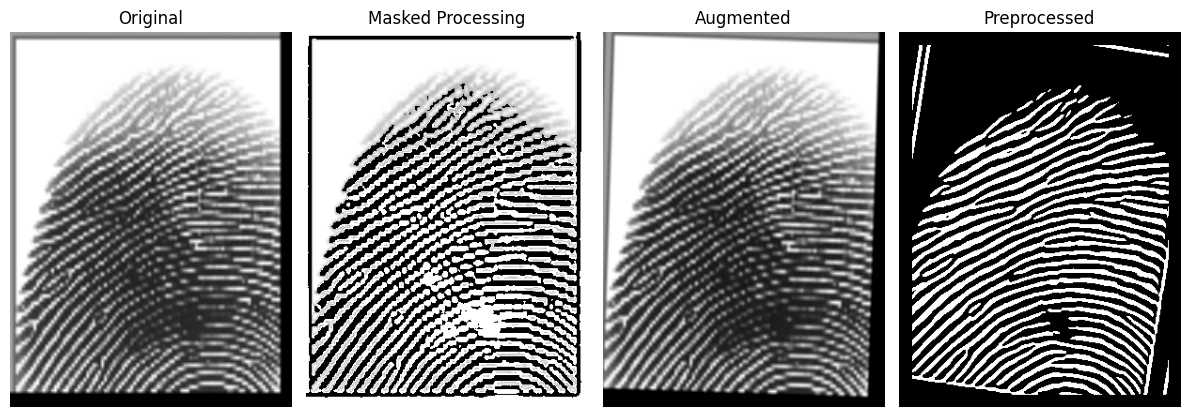

In [ ]:
# Pick an image path
image_path = "./Public_Dataset/a/cluster_0_127.BMP"

# 1. Original
orig = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
orig = cv2.resize(orig, (300, 400))

# 2. Masked Processing
masked = apply_masked_processing(orig)

# 3. Augmentation
augmented = simple_augment(orig)

# 4. Preprocessed (with augmentation ON)
preprocessed = preprocess_image(image_path, (300, 400), augment=True)

# --- Show results ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(orig, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(masked, cmap="gray")
plt.title("Masked Processing")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(augmented, cmap="gray")
plt.title("Augmented")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(preprocessed.squeeze(), cmap="gray")  # remove last channel
plt.title("Preprocessed")
plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
# Torch Dataset
class FingerprintDataset(Dataset):
    def __init__(self, data_dir, img_size=(300, 400), subset="train", val_split=0.2, augment=False):
        self.data_dir = data_dir
        self.img_size = img_size
        self.augment = augment
        self.class_names = sorted(os.listdir(data_dir))
        self.class_indices = {c: i for i, c in enumerate(self.class_names)}
        self.filepaths, self.labels = self._load_dataset(subset, val_split)

    def _load_dataset(self, subset, val_split):
        filepaths, labels = [], []
        for c in self.class_names:
            class_path = os.path.join(self.data_dir, c)
            image_files = os.listdir(class_path)
            image_paths = [os.path.join(class_path, f) for f in image_files]
            n_total = len(image_paths)
            n_val = int(n_total * val_split)
            if subset == "train":
                selected = image_paths[n_val:]
            else:
                selected = image_paths[:n_val]
            filepaths.extend(selected)
            labels.extend([self.class_indices[c]] * len(selected))
        return filepaths, labels

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]
        image = preprocess_image(img_path, self.img_size, augment=self.augment)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (C,H,W)
        return image, label

In [10]:
# Load datasets
train_dataset = FingerprintDataset(data_dir, img_size, subset="train", augment=True)
val_dataset   = FingerprintDataset(data_dir, img_size, subset="val")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Training samples per class:", Counter(train_dataset.labels))
print("Validation samples per class:", Counter(val_dataset.labels))

Training samples per class: Counter({0: 1256, 3: 1248, 1: 1172, 2: 1112})
Validation samples per class: Counter({0: 314, 3: 312, 1: 293, 2: 277})


In [11]:
# Compute class weights
class_labels = np.array(train_dataset.labels)
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = torch.tensor(weights, dtype=torch.float32)

In [12]:
# CNN Model
class FingerprintCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(FingerprintCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size[0]//8) * (img_size[1]//8), 128),
            nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

In [13]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none", weight=class_weights.to(inputs.device))
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean() if self.reduction=="mean" else focal_loss.sum()

In [30]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = FingerprintCNN(num_classes=num_classes).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using device: cpu


In [15]:
def train_one_epoch(loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss/len(loader), correct/total

def validate(loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss/len(loader), correct/total

In [16]:
# Training loop
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(train_loader)
    val_loss, val_acc = validate(val_loader)
    print(f"Epoch {epoch+1}/{epochs} "
          f"| Train Loss={train_loss:.4f}, Acc={train_acc:.4f} "
          f"| Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

  0%|          | 0/150 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Save model
torch.save(model.state_dict(), "fingerprint_cnn.pth")
print("Model saved as fingerprint_cnn.pth")